### Install dependencies

In [1]:
import os
def is_running_on_colab():
    return "COLAB_GPU" in os.environ

LOCAL = not is_running_on_colab()

In [2]:
if not LOCAL:
    !pip install petastorm -qq
    !pip install pyspark -qq
    !pip install -U -q PyDrive -qq
    !apt install openjdk-8-jdk-headless -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.0/284.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 13 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package libxtst6:amd64.
(Reading database ... 123069 files and directo

In [3]:
#@title Imports
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly

import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, DataFrame, Row
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType, FloatType, LongType
from pyspark import SparkContext, SparkConf
from pyspark.ml.linalg import SparseVector, DenseVector, VectorUDT

from tqdm.notebook import tqdm
import time
import gc

if not LOCAL:
    from google.colab import drive

from typing import Tuple
from functools import reduce
import pickle
import torch
from petastorm import make_batch_reader
from petastorm.pytorch import DataLoader

In [4]:
#@title Set up variables
if not LOCAL:
    JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
    GDRIVE_DIR = "/content/drive"
    GDRIVE_HOME_DIR = GDRIVE_DIR + "/MyDrive"
    GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + "/Big Data/datasets"
    DATASET_FILE = os.path.join(GDRIVE_DATA_DIR, "pyspark_friendly_spotify_playlist_dataset")
    AUDIO_FEATURES_FILE = os.path.join(GDRIVE_DATA_DIR, "pyspark_track_features")
    LITTLE_SLICE_FILE = os.path.join(GDRIVE_DATA_DIR, "little_slice")
    SMALL_SLICE_FLIE = os.path.join(GDRIVE_DATA_DIR, "small_slice")
    LITTLE_SLICE_AUDIO_FEATURES = os.path.join(GDRIVE_DATA_DIR, "little_slice_audio_features")
    MICRO_SLICE_AUDIO_FEATURES = os.path.join(GDRIVE_DATA_DIR, "micro_slice_audio_features")
    SPLITTED_SLICE_AUDIO_FEATURES = os.path.join(GDRIVE_DATA_DIR, "splitted_pyspark_track_features")
    SAVED_DFS_PATH = os.path.join(GDRIVE_DATA_DIR, "saved_dfs")
    SAVED_MODELS = os.path.join(GDRIVE_DATA_DIR, "saved_models")
else:
    GDRIVE_DATA_DIR = os.path.abspath("./data")
    GDRIVE_HOME_DIR = GDRIVE_DATA_DIR
    SAVED_DFS_PATH = os.path.join(GDRIVE_DATA_DIR, "saved_dfs")
    SAVED_MODELS = os.path.join(GDRIVE_DATA_DIR, "saved_models")
    JAVA_HOME = "/opt/homebrew/opt/openjdk"
RANDOM_SEED = 42 # for reproducibility
os.environ["JAVA_HOME"] = JAVA_HOME
os.environ["PYSPARK_PYTHON"]="python"

In [5]:
if not LOCAL:
    drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/drive


In [6]:
#@title Create the session
config = SparkConf().\
                set('spark.ui.port', "4050").\
                set('spark.executor.memory', '12G').\
                set('spark.driver.memory', '12G').\
                set('spark.driver.maxResultSize', '100G').\
                set("spark.executor.extraJavaOptions", "-XX:+UseG1GC").\
                setAppName("PySparkTutorial").\
                setMaster("local[*]")

# Create the context
sc = pyspark.SparkContext(conf=config)

In [7]:
spark = SparkSession.builder.getOrCreate()

# Data acquisition

In [8]:
playlist_schema_mapped = StructType([
    StructField("name", StringType(), True),
    StructField("collaborative", StringType(), True),
    StructField("pid", IntegerType(), True),
    StructField("modified_at", IntegerType(), True),
    StructField("num_tracks", IntegerType(), True),
    StructField("num_albums", IntegerType(), True),
    StructField("num_followers", IntegerType(), True),
    StructField("tracks", VectorUDT(), True),
    StructField("num_edits", IntegerType(), True),
    StructField("duration_ms", IntegerType(), True),
    StructField("num_artists", IntegerType(), True),
])


In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
NUM_PLAYLISTS = 100_000

In [11]:
# The DF used for train (80% of the original) (playlist are different)
TRAIN_DF_PATH = os.path.join(SAVED_DFS_PATH, f"train_df-{NUM_PLAYLISTS}.json")
# The DF used for testing (20% of the original) (playlist are different)
TEST_DF_PATH = os.path.join(SAVED_DFS_PATH, f"test_df-{NUM_PLAYLISTS}.json")

# The DF used for train in the NN model (can be filtered or not)
NN_TRAIN_DF_PATH = os.path.join(SAVED_DFS_PATH, f"nn_train_df-{NUM_PLAYLISTS}.json")
# The DF used for testing in the NN model (can be filtered or not)
NN_TEST_DF_PATH = os.path.join(SAVED_DFS_PATH, f"nn_test_df-{NUM_PLAYLISTS}.json")
# The partition in train test of the NN test set. (Same playlists, different songs)
NN_TEST_DF_TRAIN_PATH = os.path.join(SAVED_DFS_PATH, f"nn_test_df-train-{NUM_PLAYLISTS}.json")
NN_TEST_DF_TEST_PATH = os.path.join(SAVED_DFS_PATH, f"nn_test_df-test-{NUM_PLAYLISTS}.json")

NN_EVAL_PATH = os.path.join(SAVED_DFS_PATH, f"nn_eval_df-{NUM_PLAYLISTS}.json")
NN_EVAL_TRAIN_PATH = os.path.join(SAVED_DFS_PATH, f"nn_eval_df-train-{NUM_PLAYLISTS}.json")
NN_EVAL_TEST_PATH = os.path.join(SAVED_DFS_PATH, f"nn_eval_df-test-{NUM_PLAYLISTS}.json")
# New one:
ARTISTS_EMBEDDINGS_TRAIN = os.path.join(SAVED_DFS_PATH, f"nn_artists_embeddings-train-{NUM_PLAYLISTS}.json")
ARTISTS_EMBEDDINGS_TEST_TRAIN = os.path.join(SAVED_DFS_PATH, f"nn_artists_embeddings-test-train-{NUM_PLAYLISTS}.json")
ARTISTS_EMBEDDINGS_TEST_TEST = os.path.join(SAVED_DFS_PATH, f"nn_artists_embeddings-test-test{NUM_PLAYLISTS}.json")

ARTISTS_EMBEDDINGS_EVAL = os.path.join(SAVED_DFS_PATH, f"nn_artists_embeddings-eval-{NUM_PLAYLISTS}.json")
ARTISTS_EMBEDDINGS_EVAL_TRAIN = os.path.join(SAVED_DFS_PATH, f"nn_artists_embeddings-eval-train-{NUM_PLAYLISTS}.json")
ARTISTS_EMBEDDINGS_EVAL_TEST = os.path.join(SAVED_DFS_PATH, f"nn_artists_embeddings-eval-test{NUM_PLAYLISTS}.json")

# The length of the artist vector length (Artist vectors are only used in the NN model)
ARTIST_VECTOR_LENGTH_PATH = os.path.join(SAVED_DFS_PATH, f"nn_artist_vector_length-{NUM_PLAYLISTS}.txt")

SONGS_VECTOR_LENGTH_PATH = os.path.join(SAVED_DFS_PATH, f"songs_vector_length-{NUM_PLAYLISTS}.txt")
# This may be filtered or not
FILTERED_SONGS_VECTOR_LENGTH_PATH = os.path.join(SAVED_DFS_PATH, f"nn_songs_vector_length-{NUM_PLAYLISTS}.txt")

SONGS_EMBEDDINGS_TRAIN = os.path.join(SAVED_DFS_PATH, f"songs_embeddings-train-{NUM_PLAYLISTS}.json")
SONGS_EMBEDDINGS_TEST = os.path.join(SAVED_DFS_PATH, f"songs_embeddings-test-{NUM_PLAYLISTS}.json")

NN_SONGS_EMBEDDINGS_TRAIN = os.path.join(SAVED_DFS_PATH, f"nn_songs_embeddings-train-{NUM_PLAYLISTS}.json")
NN_SONGS_EMBEDDINGS_TEST_TRAIN = os.path.join(SAVED_DFS_PATH, f"nn_songs_embeddings-test-train-{NUM_PLAYLISTS}.json")
NN_SONGS_EMBEDDINGS_TEST_TEST = os.path.join(SAVED_DFS_PATH, f"nn_songs_embeddings-test-test-{NUM_PLAYLISTS}.json")

NN_SONGS_EMBEDDINGS_EVAL = os.path.join(SAVED_DFS_PATH, f"nn_songs_embeddings-eval-{NUM_PLAYLISTS}.json") #TODO: The logic to produce this still has to be coded.
NN_SONGS_EMBEDDINGS_EVAL_TRAIN = os.path.join(SAVED_DFS_PATH, f"nn_songs_embeddings-eval-train-{NUM_PLAYLISTS}.json")
NN_SONGS_EMBEDDINGS_EVAL_TEST = os.path.join(SAVED_DFS_PATH, f"nn_songs_embeddings-eval-test-{NUM_PLAYLISTS}.json")

SONGS_INFO_DF = os.path.join(SAVED_DFS_PATH, f"songs_info_df-{NUM_PLAYLISTS}.json")
FILTERED_SONGS_INFO_DF = os.path.join(SAVED_DFS_PATH, f"nn_songs_info_df-{NUM_PLAYLISTS}.json")

In [12]:
songs_embeddings = spark.read.schema(playlist_schema_mapped).json(NN_SONGS_EMBEDDINGS_TRAIN)
artists_embeddings = spark.read.schema(playlist_schema_mapped).json(ARTISTS_EMBEDDINGS_TRAIN)
song_mapping = spark.read.json(FILTERED_SONGS_INFO_DF)

songs_embeddings_eval_train = spark.read.schema(playlist_schema_mapped).json(NN_SONGS_EMBEDDINGS_EVAL_TRAIN)
songs_embeddings_eval_test = spark.read.schema(playlist_schema_mapped).json(NN_SONGS_EMBEDDINGS_EVAL_TEST)

artists_embeddings_eval_train = spark.read.schema(playlist_schema_mapped).json(ARTISTS_EMBEDDINGS_EVAL_TRAIN)
artists_embeddings_eval_test = spark.read.schema(playlist_schema_mapped).json(ARTISTS_EMBEDDINGS_EVAL_TEST)

with open(ARTIST_VECTOR_LENGTH_PATH, "r") as f:
  content = f.read()
  ARTIST_VECTOR_LENGTH = int(content)
with open(SONGS_VECTOR_LENGTH_PATH, "r") as f:
  content = f.read()
  SONGS_VECTOR_LENGTH = int(content)

In [13]:
songs_embeddings.show(), artists_embeddings.show(), ARTIST_VECTOR_LENGTH, SONGS_VECTOR_LENGTH

+-------------------+-------------+-----+-----------+----------+----------+-------------+--------------------+---------+-----------+-----------+
|               name|collaborative|  pid|modified_at|num_tracks|num_albums|num_followers|              tracks|num_edits|duration_ms|num_artists|
+-------------------+-------------+-----+-----------+----------+----------+-------------+--------------------+---------+-----------+-----------+
|              Alone|        false|20080| 1496880000|        50|        48|            1|(681805,[4874,542...|       19|   11128916|         42|
|       Country Hits|        false|14258| 1504828800|       130|        77|            1|(681805,[3,1666,1...|       61|   28245005|         44|
|              Peter|        false|14812| 1446595200|        65|        56|            1|(681805,[213,540,...|       15|   14212644|         47|
|          Rock.....|        false| 1938| 1500163200|        57|        39|            1|(681805,[2908,350...|        5|   1676688

(None, None, 110063, 681805)

# Convert PySpark DataFrame into PyTorch DataLoader

In [14]:
def convert_sparse_to_indices(df: DataFrame, column_name: str) -> DataFrame:
  """
  Given a dataframe fo columns "pos":int and "tracks":SparseVector, it returns a new dataframe where
  the SparseVector are replaced with a list of the indices where the values are.
  (The value information is lost, but we don't care since they are binary values so they will be all ones)
  """

  @F.udf(returnType=ArrayType(IntegerType()))
  def transform_array(item: SparseVector):
    """
    Given a SparseVector (binary) it returns the tuple that represent it, of the type (size, indices)
    """
    indices_list = item.indices.tolist()
    padding_width = max_songs - len(indices_list)
    return indices_list + [-1] * padding_width

  max_songs = songs_embeddings.select(F.max("num_tracks")).first()[0]
  print(f"Max number of songs: {max_songs}")
  df = df.withColumn(f"{column_name}_indices", transform_array(F.col(column_name))).drop(column_name)
  return df

In [15]:
def padded_tensors_to_sparse_matrix(padded_tensor: torch.Tensor, shape: tuple) -> torch.Tensor:
  batch_size, max_songs = padded_tensor.size(0), padded_tensor.size(1)
  rows = []
  for row_idx in range(batch_size):
    row = padded_tensor[row_idx]
    indices = row[row != -1]
    sparse_tensor = torch.sparse_coo_tensor(indices.unsqueeze(0), torch.ones(indices.shape), shape)
    rows.append(sparse_tensor)
  return torch.stack(rows)

def padded_tensors_to_dense_matrix(padded_tensor: torch.Tensor, shape: tuple) -> torch.Tensor:
  batch_size, max_songs = padded_tensor.size(0), padded_tensor.size(1)
  rows = []
  for row_idx in range(batch_size):
    row = padded_tensor[row_idx]
    indices = row[row != -1]
    sparse_tensor = torch.sparse_coo_tensor(indices.unsqueeze(0), torch.ones(indices.shape), shape)
    dense = sparse_tensor.to_dense()
    rows.append(dense)
  unpadded = torch.stack(rows)
  return unpadded

def padded_tensors_to_dense_matrix_fast(padded_tensor: torch.Tensor, shape: tuple) -> torch.Tensor:
    batch_size, max_songs = padded_tensor.size(0), padded_tensor.size(1)

    row_indices = torch.arange(batch_size).unsqueeze(1).repeat(1, max_songs)
    valid_mask = padded_tensor != -1

    indices = torch.stack([row_indices[valid_mask], padded_tensor[valid_mask]], dim=0)
    values = torch.ones(indices.shape[1])

    size = (batch_size, shape[0])

    sparse_tensor = torch.sparse_coo_tensor(indices, values, size)
    dense = sparse_tensor.to_dense()

    return dense

In the paper they have two matrices,l et $n$ be the number of unique songs, $m$ the number of playlists and $k$ the number of unique artists:

- $P \in \mathbb{R}^{m \times n}$ where $p_i = 1$ if song $i$ is in the playlist, $p_i=0$ otherwise
- $A \in \mathbb{R}^{m \times k}$ where $a_i=1$ if the artist is present in the playlist, $a_i = 0$ otherwise

In [16]:
from petastorm.spark import SparkDatasetConverter, make_spark_converter

CACHE = os.path.join(GDRIVE_HOME_DIR, "cache")
spark.conf.set(SparkDatasetConverter.PARENT_CACHE_DIR_URL_CONF, f'file://{CACHE}')

pytorch_songs_df = convert_sparse_to_indices(songs_embeddings.select("tracks", "pid"), column_name="tracks")
# songs_converter = make_spark_converter(pytorch_songs_df)
pytorch_artists_df = convert_sparse_to_indices(artists_embeddings.withColumnRenamed("tracks", "artists").select("pid", "artists"), column_name="artists")
# artist_converter = make_spark_converter(pytorch_artists_df)
songs_artists_df = pytorch_songs_df.join(pytorch_artists_df, on="pid")
pytorch_merged_dataloader = make_spark_converter(songs_artists_df)


print(pytorch_songs_df.count(), pytorch_artists_df.count(), songs_artists_df.count()) #Everything good here, this is nice!

Max number of songs: 250


Max number of songs: 250


98465 98465 98465


Creating the dataloader for the evaluation set

# PyTorch Model

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pickle

class DAE_tied(nn.Module):
    def __init__(self, conf):
        super(DAE_tied, self).__init__()
        self.save_dir = conf["save"]
        if LOCAL:
            self.device = torch.device("mps")
        else:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.initval_dir = conf["initval"]

        self.n_batch = conf["batch"]
        self.n_input = conf["n_input"]
        self.n_hidden = conf["hidden"]
        self.reg_lambda = conf["reg_lambda"]

        self.keep_prob = torch.tensor(conf["keep_prob"], dtype=torch.float32)
        self.input_keep_prob = torch.tensor(conf["input_keep_prob"], dtype=torch.float32)

        self.weights = {}
        self.biases = {}
        self.d_params = []

        self.z = None

    def init_weight(self):
        if self.initval_dir == 'NULL':
            self.weights['encoder_h'] = nn.Parameter(torch.FloatTensor(self.n_input, self.n_hidden).to(self.device))
            nn.init.xavier_uniform_(self.weights['encoder_h'])
            self.biases['encoder_b'] = nn.Parameter(torch.FloatTensor(self.n_hidden).to(self.device))
            nn.init.zeros_(self.biases['encoder_b'])
            self.biases['decoder_b'] = nn.Parameter(torch.FloatTensor(self.n_input).to(self.device))
            nn.init.zeros_(self.biases['decoder_b'])
        else:
            with open(self.initval_dir, 'rb') as f:
                emb = pickle.load(f)
            self.weights['encoder_h'] = nn.Parameter(torch.FloatTensor(emb[0]).to(self.device))
            self.biases['encoder_b'] = nn.Parameter(torch.FloatTensor(emb[2]).to(self.device))
            self.biases['decoder_b'] = nn.Parameter(torch.FloatTensor(emb[3]).to(self.device))
        self.d_params = [self.weights['encoder_h'], self.weights['encoder_h'], self.biases['encoder_b'], self.biases['decoder_b']]


    # Building the encoder
    def encoder(self, x):
        # Encoder Hidden layer with sigmoid activation #1
        layer = torch.add(torch.matmul(x, self.weights['encoder_h']), self.biases['encoder_b'])
        layer = torch.sigmoid(layer)
        layer = torch.nn.functional.dropout(layer, p=1 - self.keep_prob)

        return layer

    # Building the decoder
    def decoder(self, x):
        # Decoder Hidden layer with sigmoid activation #1
        layer = torch.sigmoid(torch.add(torch.matmul(x, self.weights['encoder_h'].t()), self.biases['decoder_b']))
        return layer

    def l2_loss(self):
        # encoder_h_l2 = (torch.sum(self.weights['encoder_h']) ** 2)/2
        # decoder_b_l2 = (torch.sum(self.biases['decoder_b']) ** 2)/2
        # encoder_b_l2 = (torch.sum(self.biases['encoder_b']) ** 2)/2

        encoder_h_l1 = torch.sum(torch.abs(self.weights['encoder_h']))
        decoder_b_l1 = torch.sum(torch.abs(self.biases['decoder_b']))
        encoder_b_l1 = torch.sum(torch.abs(self.biases['encoder_b']))

        # l2 = encoder_h_l2 + decoder_b_l2 + encoder_b_l2
        l1 = encoder_h_l1 + decoder_b_l1 + encoder_b_l1
        return l1

    def forward(self, x, y):
        self.x = x
        self.y = y

        x_dropout = torch.nn.functional.dropout(self.x, p= 1 - self.input_keep_prob)
        reduce_sum = torch.sum(x_dropout, dim=1, keepdim=True)
        self.x_dropout = torch.div(x_dropout, reduce_sum + 1e-10)

        encoder_op = self.encoder(self.x_dropout)

        self.z = encoder_op
        self.y_pred = self.decoder(encoder_op)

        l2 = self.l2_loss()

        ALPHA = 0.5

        L = -torch.sum(self.y * torch.log(self.y_pred + 1e-10) +
                       ALPHA * (1 - self.y) * torch.log(1 - self.y_pred + 1e-10), dim=1)

        self.cost = torch.mean(L) + self.reg_lambda * l2

    def save_model(self):
        params = [param.detach().numpy() for param in self.d_params]
        with open(self.save_dir, 'wb') as f:
            pickle.dump(params, f)


class DAE(DAE_tied):
    def __init__(self, conf):
        super(DAE, self).__init__(conf)

    def init_weight(self):
        if self.initval_dir == 'NULL':
            self.weights['encoder_h'] = nn.Parameter(torch.FloatTensor(self.n_input, self.n_hidden).to(self.device))
            nn.init.xavier_uniform_(self.weights['encoder_h'])
            self.weights['decoder_h'] = nn.Parameter(torch.FloatTensor(self.n_input, self.n_hidden).to(self.device))
            nn.init.xavier_uniform_(self.weights['decoder_h'])
            self.biases['encoder_b'] = nn.Parameter(torch.FloatTensor(self.n_hidden).to(self.device))
            nn.init.zeros_(self.biases['encoder_b'])
            self.biases['decoder_b'] = nn.Parameter(torch.FloatTensor(self.n_input).to(self.device))
            nn.init.zeros_(self.biases['decoder_b'])
        else:
            with open(self.initval_dir, 'rb') as f:
                emb = pickle.load(f)
            self.weights['encoder_h'] = nn.Parameter(torch.FloatTensor(emb[0]).to(self.device))
            self.weights['decoder_h'] = nn.Parameter(torch.FloatTensor(emb[1]).to(self.device))
            self.biases['encoder_b'] = nn.Parameter(torch.FloatTensor(emb[2]).to(self.device))
            self.biases['decoder_b'] = nn.Parameter(torch.FloatTensor(emb[3]).to(self.device))

        self.d_params = [self.weights['encoder_h'], self.weights['decoder_h'],
                         self.biases['encoder_b'], self.biases['decoder_b']]

    def decoder(self, x):
        # Decoder Hidden layer with sigmoid activation #1
        layer = torch.sigmoid(torch.add(torch.matmul(x, self.weights['decoder_h'].t()), self.biases['decoder_b']))
        return layer

    def l2_loss(self):
    #   encoder_h_l2 = (torch.sum(self.weights['encoder_h']) ** 2)/2
    #   decoder_b_l2 = (torch.sum(self.biases['decoder_b']) ** 2)/2
    #   encoder_b_l2 = (torch.sum(self.biases['encoder_b']) ** 2)/2
    #   decoder_h_l2 = (torch.sum(self.weights['decoder_h']) ** 2)/2

      encoder_h_l1 = torch.sum(torch.abs(self.weights['encoder_h']))
      decoder_b_l1 = torch.sum(torch.abs(self.biases['decoder_b']))
      encoder_b_l1 = torch.sum(torch.abs(self.biases['encoder_b']))
      decoder_h_l1 = torch.sum(torch.abs(self.weights['decoder_h']))


      l1 = encoder_h_l1 + decoder_b_l1 + encoder_b_l1 + decoder_h_l1

    #   l2 = encoder_h_l2 + decoder_b_l2 + encoder_b_l2 + decoder_h_l2

      return l1

In [18]:
pytorch_songs_eval_train_df = convert_sparse_to_indices(songs_embeddings_eval_train.withColumnRenamed("tracks", "train_tracks").select("train_tracks", "pid"), column_name="train_tracks")
pytorch_artists_eval_train_df = convert_sparse_to_indices(artists_embeddings_eval_train.withColumnRenamed("tracks", "train_artists").select("pid", "train_artists"), column_name="train_artists")
songs_artists_eval_train_df = pytorch_songs_eval_train_df.join(pytorch_artists_eval_train_df, on="pid")

pytorch_songs_eval_test_df = convert_sparse_to_indices(songs_embeddings_eval_test.withColumnRenamed("tracks", "test_tracks").select("test_tracks", "pid"), column_name="test_tracks")
pytorch_artists_eval_test_df = convert_sparse_to_indices(artists_embeddings_eval_test.withColumnRenamed("tracks", "test_artists").select("pid", "test_artists"), column_name="test_artists")
songs_artists_eval_test_df = pytorch_songs_eval_test_df.join(pytorch_artists_eval_test_df, on="pid")

eval_merged_df = songs_artists_eval_train_df.join(songs_artists_eval_test_df, on="pid")

# counter = F.udf(lambda x: len([item for item in x if item != -1]), returnType=IntegerType())
# eval_merged_df = eval_merged_df\
#     .withColumn("train_tracks_count", counter(F.col("train_tracks_indices")))\
#     .withColumn("test_tracks_count", counter(F.col("test_tracks_indices")))
# eval_merged_df = eval_merged_df.filter("train_tracks_count > 100")
eval_merged_dataloader = make_spark_converter(eval_merged_df)

eval_merged_num = eval_merged_df.count()

Max number of songs: 250
Max number of songs: 250
Max number of songs: 250


Max number of songs: 250


In [19]:
if LOCAL:
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
from typing import List
def k_prec(input: torch.Tensor, eval_preds: torch.Tensor, ground_truth: torch.Tensor) -> List[float]:
    batch_size = 10
    precs = []

    for i in range(batch_size):

        if ground_truth.shape[0] != batch_size:
          continue
        input_idx = torch.nonzero(input[i] == 1).squeeze().flatten()
        num_input_songs = input_idx.shape[0]

        ground_truth_idx = torch.nonzero(ground_truth[i] == 1).squeeze().flatten()
        num_ground_truth_songs = ground_truth_idx.shape[0]

        if num_ground_truth_songs == 0:
          continue

        k = num_input_songs + num_ground_truth_songs
        top_k_preds = eval_preds[i].topk(k, dim=0)
        top_k_preds_idx = top_k_preds.indices.flatten().cpu()

        confidences = top_k_preds.values.flatten()

        already_in_playlist = np.intersect1d(top_k_preds_idx.detach().numpy(), input_idx.cpu().detach().numpy())

        top_k_preds_idx = np.array([item for item in top_k_preds_idx.detach().numpy() if item not in already_in_playlist])[:num_ground_truth_songs]

        common_elements = np.intersect1d(top_k_preds_idx, ground_truth_idx.cpu().detach().numpy())
        num_common_elements = len(common_elements)
        precs.append(num_common_elements/num_ground_truth_songs)

    return precs

def ndcg(eval_preds: torch.Tensor, ground_truth: torch.Tensor) -> float:
    return 0

def evaluate(input: torch.Tensor, eval_preds: torch.Tensor, ground_truth: torch.Tensor) -> List[float]:
    return k_prec(input, eval_preds, ground_truth)

In [21]:
def test_k_prec(eval_preds: torch.Tensor, ground_truth: torch.Tensor) -> List[float]:
    batch_size = 10
    precs = []

    for i in range(batch_size):
        ground_truth_idx = torch.nonzero(ground_truth[i] == 1).squeeze().flatten()
        num_ground_truth_songs = ground_truth_idx.shape[0]

        k = num_ground_truth_songs
        top_k_preds = eval_preds[i].topk(k, dim=0)
        top_k_preds_idx = top_k_preds.indices.flatten().cpu()

        confidences = top_k_preds.values.flatten()

        common_elements = np.intersect1d(top_k_preds_idx, ground_truth_idx.cpu().detach().numpy())
        num_common_elements = len(common_elements)
        precs.append(num_common_elements/num_ground_truth_songs)

    return precs

Creating the petastorm converters for validation set

In [22]:
def validate(model: DAE_tied) -> Tuple[torch.Tensor, float, float]:
    """
    Given the model, performs an evaluation on the validation set.
    """
    ARTIST_SHAPE = (ARTIST_VECTOR_LENGTH, )
    SONG_SHAPE = (SONGS_VECTOR_LENGTH, )
    precs = []
    tot_k = 0
    model.eval()
    with eval_merged_dataloader.make_torch_dataloader(batch_size=10, num_epochs = 1) as eval_dataloader:
        for batch_idx, row in enumerate(eval_dataloader):
            with torch.no_grad():
                # if batch_idx == 1:
                    # break #TODO: faster but less generalized, remove for the final training
                padded_eval_song_tensor = row["train_tracks_indices"]
                padded_eval_artist_tensor = row["train_artists_indices"]

                song_dense = padded_tensors_to_dense_matrix(padded_eval_song_tensor, SONG_SHAPE)
                artist_dense = padded_tensors_to_dense_matrix(padded_eval_artist_tensor, ARTIST_SHAPE)

                song_dense = song_dense.to(device)
                artist_dense = artist_dense.to(device)

                del padded_eval_song_tensor
                del padded_eval_artist_tensor

                x = torch.concat((song_dense, artist_dense), dim=1)
                y = torch.concat((song_dense, artist_dense), dim=1)

                model(x, y)

                eval_preds = model.y_pred[:, :SONGS_VECTOR_LENGTH]

                padded_eval_song_tensor_test = row["test_tracks_indices"]

                ground_truth = padded_tensors_to_dense_matrix(padded_eval_song_tensor_test, SONG_SHAPE)

                ground_truth = ground_truth.to(device)

                prec_list = evaluate(song_dense, eval_preds, ground_truth)
                precs.extend(prec_list)

        mean_prec: float = sum(precs) / len(precs)
        model.train()
        return model.cost, mean_prec


Define the validation function that is invoked during the training in order to save the model parameters that optimize the performance evaluation on the validation set.

In [23]:
def perform_validation_step(model: DAE_tied, max_prec: float, save_path:str, save: bool):
    eval_loss, prec = validate(model)

    if prec > max_prec:
        max_prec = prec
        best_params = [param.cpu().detach().numpy() for param in model.d_params]
        if save:
          with open(save_path, "wb") as f:
              pickle.dump(best_params, f)
          print(f"Best prec achieved: {prec}, parameters saved!")
        else:
          print(f"Best prec achieved: {prec}!")
    return max_prec

In [24]:
BEST_PARAMS_PATH = os.path.join(SAVED_MODELS, "best_params.pickle")
BEST_PARAMS_PATH_2 = os.path.join(SAVED_MODELS, "best_params_reg.pickle")

#Hyperparameters used in the paper
conf = {
    'batch': 100,
    'n_input': SONGS_VECTOR_LENGTH + ARTIST_VECTOR_LENGTH,
    'hidden': 256,
    'lr': 0.0005,
    'reg_lambda': 0.0,
    'initval': "NULL",
    "keep_prob": 0.8,
    "input_keep_prob": 0.8, # This isn't used for now because of the .uniform()
    'save': os.path.join(SAVED_MODELS, "dae_model.pickle")
}

In [ ]:
pretrain_model = DAE_tied(conf)
pretrain_model.init_weight()
pretrain_model.train()

In [74]:
pretrain_optimizer = optim.Adam(pretrain_model.d_params, lr=conf["lr"])

In [75]:
pretrain_model.weights['encoder_h'].device

device(type='cuda', index=0)

In [76]:
torch.cuda.empty_cache()

## Train the model

In [25]:
min_loss = 2000
max_prec = 0.01
max_test_prec = 0
best_params = []
losses = []

Pretrain with `DAE_tied`

In [ ]:
from tqdm.notebook import tqdm
import random
# os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
NUM_EPOCHS = 50
with pytorch_merged_dataloader.make_torch_dataloader(batch_size=conf["batch"], num_epochs = NUM_EPOCHS) as train_dataloader:
    SONG_SHAPE = (SONGS_VECTOR_LENGTH, )
    ARTIST_SHAPE = (ARTIST_VECTOR_LENGTH, )
    for batch_idx, row in tqdm(enumerate(train_dataloader), desc=f"Training model", total= (NUM_PLAYLISTS / conf["batch"]) * NUM_EPOCHS):
      # Pick random input_keep_prob between 0.5 and 0.8
      pretrain_model.input_keep_prob = random.uniform(0.5, 0.8) #TODO: make this dynamic inside the conf

      padded_song_tensor = row["tracks_indices"]
      padded_artist_tensor = row["artists_indices"]

      song_dense = padded_tensors_to_dense_matrix(padded_song_tensor, SONG_SHAPE)
      artist_dense = padded_tensors_to_dense_matrix(padded_artist_tensor, ARTIST_SHAPE)

      song_dense = song_dense.to(device)
      artist_dense = artist_dense.to(device)

      rand_int = np.random.randint(2)
      if rand_int == 0:
        #Zero-out the artists
        pretrain_optimizer.zero_grad()
        x = torch.concat((song_dense, torch.zeros_like(artist_dense)), dim=1)
        # x = torch.concat((song_dense, artist_dense), dim=1)
        y = torch.concat((song_dense, artist_dense), dim=1)
        pretrain_model(x, y)
        loss = pretrain_model.cost
        pretrain_model.cost.backward()
        pretrain_optimizer.step()
      if rand_int == 1:
        #Zero-out the tracks
        pretrain_optimizer.zero_grad()
        x = torch.concat((torch.zeros_like(song_dense), artist_dense), dim=1)
        # x = torch.concat((song_dense, artist_dense), dim=1)
        y = torch.concat((song_dense, artist_dense), dim=1)
        pretrain_model(x, y)
        loss = pretrain_model.cost
        pretrain_model.cost.backward()
        pretrain_optimizer.step()

      losses.append(loss)

      if batch_idx % 1000 == 0:
        max_prec = perform_validation_step(pretrain_model, max_prec, BEST_PARAMS_PATH, save=True)
        print(f"Loss: {loss}")
        print(f"Current max precision: {max_prec}")

Training model:   0%|          | 0/50000.0 [00:00<?, ?it/s]

Best prec achieved: 0.0652841740696658, parameters saved!
Loss: 555.4766235351562
Current max precision: 0.0652841740696658
Loss: 506.506591796875
Current max precision: 0.0652841740696658
Best prec achieved: 0.06933045716177416, parameters saved!
Loss: 494.8131103515625
Current max precision: 0.06933045716177416
Best prec achieved: 0.07013826569713057, parameters saved!
Loss: 523.2730712890625
Current max precision: 0.07013826569713057
Best prec achieved: 0.07259800662562141, parameters saved!
Loss: 608.2797241210938
Current max precision: 0.07259800662562141
Loss: 473.7826843261719
Current max precision: 0.07259800662562141
Best prec achieved: 0.07503012409782188, parameters saved!
Loss: 510.06732177734375
Current max precision: 0.07503012409782188
Best prec achieved: 0.07915146271568177, parameters saved!
Loss: 384.23773193359375
Current max precision: 0.07915146271568177
Best prec achieved: 0.07917328833648327, parameters saved!
Loss: 490.74267578125
Current max precision: 0.079173

In [ ]:
pretrain_model.y_pred[0].cpu().detach().numpy().tolist()

In [ ]:
params = [param.cpu().detach().numpy() for param in pretrain_model.d_params]
with open(BEST_PARAMS_PATH_2, 'wb') as f:
  pickle.dump(params, f)

Train with `DAE` loading the pretrained `DAE_tied` model

In [26]:
FINE_TUNED_BEST_PARAMS_PATH = os.path.join(SAVED_MODELS, "final_best_params.pickle")

conf_train = conf.copy()
conf_train["initval"] = FINE_TUNED_BEST_PARAMS_PATH #TODO: put BEST_PARAMS_PATH
conf_train["lr"] = conf["lr"] / 2 # I also used a * 10 in the last 13 epochs

dae_model = DAE(conf_train)
dae_model.init_weight()
optimizer = optim.Adam(dae_model.d_params, lr=conf_train['lr'])

min_loss = 600
losses = []
best_params = []
max_prec = 0.01

In [40]:
torch.cuda.empty_cache()

In [39]:
from tqdm.notebook import tqdm
import random
NUM_EPOCHS = 100
with pytorch_merged_dataloader.make_torch_dataloader(batch_size=conf["batch"], num_epochs = NUM_EPOCHS) as train_dataloader:
    ARTIST_SHAPE = (ARTIST_VECTOR_LENGTH, )
    SONG_SHAPE = (SONGS_VECTOR_LENGTH, )
    for batch_idx, row in tqdm(enumerate(train_dataloader), desc=f"Training model", total= (NUM_PLAYLISTS / conf["batch"]) * NUM_EPOCHS):
      # Pick random input_keep_prob between 0.5 and 0.8
      dae_model.input_keep_prob = random.uniform(0.5, 0.8) #TODO: make this dynamic inside the conf

      padded_song_tensor = row["tracks_indices"]
      padded_artist_tensor = row["artists_indices"]

      song_dense = padded_tensors_to_dense_matrix(padded_song_tensor, SONG_SHAPE)
      artist_dense = padded_tensors_to_dense_matrix(padded_artist_tensor, ARTIST_SHAPE)

      song_dense = song_dense.to(device)
      artist_dense = artist_dense.to(device)

      rand_int = np.random.randint(2)
      if rand_int == 0:
        #Zero-out the artists
        optimizer.zero_grad()
        x = torch.concat((song_dense, torch.zeros_like(artist_dense)), dim=1)
        y = torch.concat((song_dense, artist_dense), dim=1)
        dae_model(x, y)
        loss = dae_model.cost
        dae_model.cost.backward()
        optimizer.step()
      if rand_int == 1:
        #Zero-out the tracks
        optimizer.zero_grad()
        x = torch.concat((torch.zeros_like(song_dense), artist_dense), dim=1)
        y = torch.concat((song_dense, artist_dense), dim=1)
        dae_model(x, y)
        loss = dae_model.cost
        dae_model.cost.backward()
        optimizer.step()

      losses.append(loss)


      if batch_idx % 1000 == 0:
        max_prec = perform_validation_step(dae_model, max_prec, FINE_TUNED_BEST_PARAMS_PATH, save=True)
        print(f"Loss: {loss}")
        print(f"Current max precision: {max_prec}")

Training model:   0%|          | 0/20000.0 [00:00<?, ?it/s]

Loss: 301.8986511230469
Current max precision: 0.1254107067481585
Loss: 276.1400146484375
Current max precision: 0.1254107067481585
Loss: 284.59051513671875
Current max precision: 0.1254107067481585
Loss: 278.4619445800781
Current max precision: 0.1254107067481585
Loss: 309.0995178222656
Current max precision: 0.1254107067481585
Loss: 353.1211242675781
Current max precision: 0.1254107067481585
Loss: 252.77389526367188
Current max precision: 0.1254107067481585


KeyboardInterrupt: ignored

In [37]:
dae_model.y_pred[0].cpu().detach().numpy().tolist()

[0.010354465804994106,
 8.565883419242581e-11,
 2.914488095306922e-12,
 4.368662376297294e-11,
 1.9959502800537265e-11,
 1.1472071491880342e-05,
 8.951109187194106e-09,
 7.939233270803925e-09,
 6.56691611311544e-07,
 2.9288584890707625e-09,
 2.0231309960649924e-09,
 5.4952754447840884e-21,
 0.00044578895904123783,
 9.463852812530149e-09,
 4.1644368509174967e-10,
 4.331647020239249e-12,
 9.87958714837589e-10,
 1.3137759977133179e-11,
 1.7127406160000191e-09,
 4.24816172892818e-17,
 6.099314759921981e-06,
 7.01835187189026e-11,
 5.700361072058513e-08,
 2.2764552909393387e-07,
 3.240618537403428e-11,
 1.6706076166883577e-07,
 0.00018699353677220643,
 2.1206709999166407e-10,
 3.0335461920216744e-10,
 3.406832871366561e-10,
 9.452834348611105e-12,
 4.4333170080790296e-05,
 9.49809040269634e-23,
 2.1226260192027317e-17,
 5.219952799961902e-05,
 7.717922017036472e-07,
 8.83227047054902e-10,
 2.2106644639863227e-11,
 5.603951979584322e-16,
 2.989143763239277e-13,
 1.3054086730508133e-18,
 5.58

Let's see how the loss decreases

In [ ]:
SAVE_MODEL_PATH = os.path.join(SAVED_DFS_PATH, f"model_new.pickle")
params = [param.cpu().detach().numpy() for param in dae_model.d_params]
with open(SAVE_MODEL_PATH, 'wb') as f:
  pickle.dump(params, f)

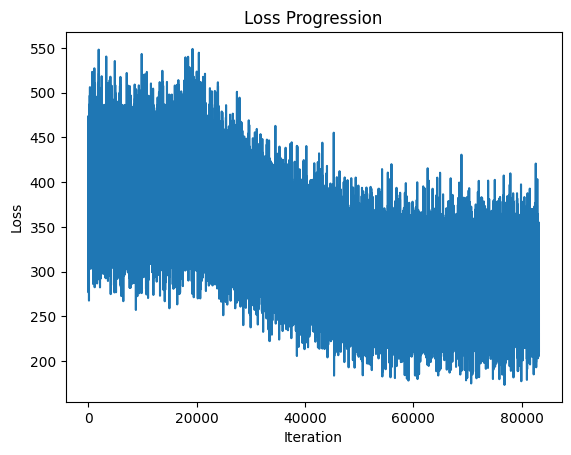

In [41]:
import matplotlib.pyplot as plt
x = np.arange(len(losses))
plt.plot(x, [loss.item() for loss in losses])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Progression')
plt.show()

# Inference

In [42]:
song_schema = StructType([
    StructField("pos", IntegerType(), True),
    StructField("artist_name", StringType(), True),
    StructField("track_uri", StringType(), True),
    StructField("artist_uri", StringType(), True),
    StructField("track_name", StringType(), True),
    StructField("album_uri", StringType(), True),
    StructField("duration_ms", LongType(), True),
    StructField("album_name", StringType(), True)
])

playlist_schema = StructType([
    StructField("name", StringType(), True),
    StructField("collaborative", StringType(), True),
    StructField("pid", IntegerType(), True),
    StructField("modified_at", IntegerType(), True),
    StructField("num_tracks", IntegerType(), True),
    StructField("num_albums", IntegerType(), True),
    StructField("num_followers", IntegerType(), True),
    StructField("tracks", ArrayType(song_schema), True),
    StructField("num_edits", IntegerType(), True),
    StructField("duration_ms", IntegerType(), True),
    StructField("num_artists", IntegerType(), True),
])

In [43]:
SONGS_EMBEDDINGS_PATH_TEST_TRAIN = os.path.join(SAVED_DFS_PATH, f"nn_songs_embeddings-test-train-{NUM_PLAYLISTS}.json")
SONGS_EMBEDDINGS_PATH_TEST_TEST = os.path.join(SAVED_DFS_PATH, f"nn_songs_embeddings-test-test-{NUM_PLAYLISTS}.json")

ARTISTS_EMBEDDINGS_PATH_TEST_TRAIN = os.path.join(SAVED_DFS_PATH, f"nn_artists_embeddings-test-train-{NUM_PLAYLISTS}.json")
ARTISTS_EMBEDDINGS_PATH_TEST_TEST = os.path.join(SAVED_DFS_PATH, f"nn_artists_embeddings-test-test{NUM_PLAYLISTS}.json")

songs_embeddings_test_train = spark.read.schema(playlist_schema_mapped).json(SONGS_EMBEDDINGS_PATH_TEST_TRAIN)
songs_embeddings_test_test = spark.read.schema(playlist_schema_mapped).json(SONGS_EMBEDDINGS_PATH_TEST_TEST)

artists_embeddings_test_train = spark.read.schema(playlist_schema_mapped).json(ARTISTS_EMBEDDINGS_PATH_TEST_TRAIN)
artists_embeddings_test_test = spark.read.schema(playlist_schema_mapped).json(ARTISTS_EMBEDDINGS_PATH_TEST_TEST)

TEST_TRAIN_DF_PATH = os.path.join(SAVED_DFS_PATH, f"nn_test_df-train-{NUM_PLAYLISTS}.json")
TEST_TEST_DF_PATH = os.path.join(SAVED_DFS_PATH, f"nn_test_df-test-{NUM_PLAYLISTS}.json")

test_train_df = spark.read.schema(playlist_schema).json(TEST_TRAIN_DF_PATH)
test_test_df = spark.read.schema(playlist_schema).json(TEST_TEST_DF_PATH)

# Evaluation

Create Test Dataloader

In [53]:
pytorch_songs_test_train_df = convert_sparse_to_indices(songs_embeddings_test_train.withColumnRenamed("tracks", "train_tracks").select("train_tracks", "pid"), column_name="train_tracks")
pytorch_artists_test_train_df = convert_sparse_to_indices(artists_embeddings_test_train.withColumnRenamed("tracks", "train_artists").select("pid", "train_artists"), column_name="train_artists")
songs_artists_test_train_df = pytorch_songs_test_train_df.join(pytorch_artists_test_train_df, on="pid")

pytorch_songs_test_test_df = convert_sparse_to_indices(songs_embeddings_test_test.withColumnRenamed("tracks", "test_tracks").select("test_tracks", "pid"), column_name="test_tracks")
pytorch_artists_test_test_df = convert_sparse_to_indices(artists_embeddings_test_test.withColumnRenamed("tracks", "test_artists").select("pid", "test_artists"), column_name="test_artists")
songs_artists_test_test_df = pytorch_songs_test_test_df.join(pytorch_artists_test_test_df, on="pid")

test_merged_df = songs_artists_test_train_df.join(songs_artists_test_test_df, on="pid")

# MIN_TRACK_COUNT = 50
# MAX_TRACK_COUNT = 100
# counter = F.udf(lambda x: len([item for item in x if item != -1]), returnType=IntegerType())
# test_merged_df = test_merged_df\
#     .withColumn("train_tracks_count", counter(F.col("train_tracks_indices")))\
#     .withColumn("test_tracks_count", counter(F.col("test_tracks_indices")))
# test_merged_df = test_merged_df.filter(f"train_tracks_count >= {MIN_TRACK_COUNT}").filter((f"train_tracks_count <= {MAX_TRACK_COUNT}"))
test_merged_dataloader = make_spark_converter(test_merged_df)

Max number of songs: 250
Max number of songs: 250
Max number of songs: 250
Max number of songs: 250


In [ ]:
test_merged_df.count()

Define function to perform the full evaluation

In [45]:
def perform_evaluation(model: DAE_tied) -> Tuple[torch.Tensor, float, float]:
    """
    Given the model, performs an evaluation on the validation set.
    """
    ARTIST_SHAPE = (ARTIST_VECTOR_LENGTH, )
    SONG_SHAPE = (SONGS_VECTOR_LENGTH, )
    precs = []
    tot_k = 0
    model.eval()
    with test_merged_dataloader.make_torch_dataloader(batch_size=10, num_epochs = 1) as test_dataloader:
        for batch_idx, row in enumerate(tqdm(test_dataloader, "Testing...")):
            with torch.no_grad():
                padded_eval_song_tensor = row["train_tracks_indices"]
                padded_eval_artist_tensor = row["train_artists_indices"]

                song_dense = padded_tensors_to_dense_matrix(padded_eval_song_tensor, SONG_SHAPE)
                artist_dense = padded_tensors_to_dense_matrix(padded_eval_artist_tensor, ARTIST_SHAPE)

                song_dense = song_dense.to(device)
                artist_dense = artist_dense.to(device)

                del padded_eval_song_tensor
                del padded_eval_artist_tensor

                x = torch.concat((song_dense, artist_dense), dim=1)
                y = torch.concat((song_dense, artist_dense), dim=1)

                model(x, y)

                eval_preds = model.y_pred[:, :SONGS_VECTOR_LENGTH]

                padded_eval_song_tensor_test = row["test_tracks_indices"]

                ground_truth = padded_tensors_to_dense_matrix(padded_eval_song_tensor_test, SONG_SHAPE)

                ground_truth = ground_truth.to(device)

                prec_list = evaluate(song_dense, eval_preds, ground_truth)
                precs.extend(prec_list)

        mean_prec: float = sum(precs) / len(precs)
        return model.cost, mean_prec

Creating the dataloaders for the test set

In [46]:
conf_test = conf_train.copy()
conf_test["batch"] = 10
conf_test["initval"] = FINE_TUNED_BEST_PARAMS_PATH

dae_model_test = DAE(conf_test)
dae_model_test.init_weight()
dae_model_test.eval()

DAE()

In [47]:
torch.cuda.empty_cache()

In [56]:
_, mean_prec = perform_evaluation(dae_model_test)

Testing...: 0it [00:00, ?it/s]

In [57]:
mean_prec

0.13159154840076953